In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from IPython.core.display import display, HTML

In [2]:
def read_data(files, path, keyword):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if keyword in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:%S.%f')
    return df

In [4]:
def aggregate(df, time, name):
    agg = df.groupby([pd.Grouper(freq= str(time) + 'Min', key = 'time'), name])[name].count().\
    reset_index(name = 'count')
    return agg

In [5]:
def get_top_frequent(df, name, number):
    sort_df = df.sort_values(by='count', ascending = False).reset_index(drop = True) 
    lst = sort_df.loc[:number, name].tolist()
    return lst

In [6]:
def draw_error(df, alert, viewchange, time, name):
    
    df = df.sort_values(by='time').reset_index(drop = True)
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "") + name + ".html"
    png_path = fig_dir 
    print("png graphs saved in " + png_path)
    print('html graphs saved in ')
    display(HTML("<a href='" + html_path + "' target='_blank'>" + html_path + "</a>"))
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    fig = px.line(df, x="time", y="count", color=name, color_discrete_sequence=px.colors.qualitative.Set2, \
              title = name + ' counts in ' + str(time) + ' minutes vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=-0.05, y=-0.6))
    
    trace = []
    text = []
    for k,v in alert.items():
        fig.add_shape(type="line", x0=k, y0=0,x1=k,y1=1,
                line=dict(
                width=0.5,
            ))
        trace.append(k)
        text.append(v)
    
    
    for i in range(len(viewchange)):
        if viewchange.message[i] == 'NewView':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    color="LightSeaGreen",    

                ))

        if viewchange.message[i] == 'StartViewChange':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    dash="dashdot",
                    color="MediumPurple",    
                    ))
            
        if viewchange.message[i] == 'ResetViewChange':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    dash="longdash",
                    color="RoyalBlue",    
                    ),
                    opacity=0.5)
    
    fig.update_shapes(dict(xref='x', yref='paper'))
    
    newView = viewchange[viewchange.message == 'NewView'].iloc[0]
    startChange = viewchange[viewchange.message == 'StartViewChange'].iloc[0]
    resetChange = viewchange[viewchange.message == 'ResetViewChange'].iloc[0]
    lst = [startChange, newView, resetChange]

    for i in range(len(lst)):
        trace.insert(0, lst[i].time)
        text.insert(0, lst[i].message)
              
    fig.add_trace(go.Scatter(
        x=trace,
        y=np.linspace(df['count'].min()*1.2, df['count'].max()*0.9, num = len(text)).tolist(),
        text=text,
        mode="text",
        showlegend=False
    ))
    

    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_dir + name + ".html")
    fig.write_image(png_path + name + ".png",width=1000, height=600)

In [7]:
# get alert time from pagerduty
alert = dict()
alert['2020-03-31 11:24:18.0'] = 'Shard 0 stuck!'
alert['2020-03-31 11:16:47.0'] = 'Shard 2 stuck!'
alert['2020-03-31 07:15:15.0'] = 'Shard 3 stuck!'
alert['2020-03-31 07:15:24.0'] = 'Shard 1 stuck!'
alert['2020-03-30 20:52:40.0'] = 'Shard 0 stuck!'
alert['2020-03-30 20:52:32.0'] = 'Shard 2 stuck!'
alert['2020-03-30 20:52:37.0'] = 'Shard 3 stuck!'
alert['2020-03-30 20:52:31.0'] = 'Shard 1 stuck!'

In [8]:
log_dir = "/home/ubuntu/jupyter/logs/debug/20200331/shard3/leader/"
html_dir = "../../docs/graphs/crash_analysis/mainnet/03-31/shard3-leader/"
fig_dir = "../../graphs/crash_analysis/mainnet/03-31/shard3-leader/"
files = os.listdir(log_dir)

### get the top sender 

some metrics
- total 124 different senders
- max: 9428
- min: 24
- \> 9000 errors: 44 senders
- \> 8000 errors: 51 senders
- \> 5000 errors: 52 senders
- \> 3000 errors: 113 senders

In [9]:
data = read_data(files, log_dir, 'overrun')
df = data_processing(data)
sender = df.groupby('sender')['sender'].count().reset_index(name = 'count') 
sender.sort_values(by='count', ascending = False).reset_index(drop = True)

,sender,count
0,Qmea5pZ4vwEbsVTob92sLeg9SQk5o91pR7bU67x9VzbkWU,9248
1,QmQQE4eWgW79vN8pLzznRNdHRRi6nWZ4RL352S6xJCSeu1,9248
2,QmZft5PhMxZoQx1sczcXtSt2tD4bFhjLCQWSoQPzTbz5GX,9248
3,QmdB3AhjX9snFsynMkp53VgE8tEnqztcbBN8fS5S9jhwGd,9248
4,Qmcxvs5mcDHu5S83t8Z1JqztPVsP2AzzusYy7U2GfHdgmF,9248
...,...,...
119,QmfAvzBRz2SppA5ozxw1nPfgqzAZQfVBTphvrJYqP9kTxN,1182
120,Qmc1ooNobR9uq7RZkGpfQGSeJB2fZCHSUHXfkrSpzaDH7G,815
121,QmY5LbbKPTKtbWY9HLcQ7AF3LU6tU5M3pM75vinQw3qjCZ,503
122,QmWHHRUTojdTFEGDi2thDpNVXbs5PiLvnyAAsHZ6RHraZe,58


In [10]:
sender.describe()

,count
count,124.000000
mean,5474.717742
std,3157.392082
min,24.000000
25%,3081.000000
50%,3086.000000
75%,9231.500000
max,9248.000000


In [11]:
lst = get_top_frequent(sender, 'sender', 51)
mask = df['sender'].apply(lambda x: x in lst)
df_2 = df[mask]

### add view change time

In [12]:
data = read_data(files, log_dir, 'start view change timer')
startViewChange = data_processing(data)[['time','message']]
startViewChange['message'] = 'StartViewChange'

data = read_data(files, log_dir, 'Resetting view change state')
resetViewChange = data_processing(data)[['time','message']]
resetViewChange['message'] = 'ResetViewChange'

data = read_data(files, log_dir, 'Received NewView Message')
newview = data_processing(data)[['time','message']]
newview['message'] = 'NewView'

viewchange = pd.concat([startViewChange, resetViewChange, newview], ignore_index=True)

### aggregate on five minutes level

In [13]:
agg = aggregate(df_2, 5, 'sender')
agg.sort_values(by='count', ascending = False).reset_index(drop = True)

,time,sender,count
0,2020-03-31 01:00:00+00:00,QmVKuF9RXEVUTcpQfLcdExFNgxaza22pXYG4tKGr59E4V4,156
1,2020-03-31 01:00:00+00:00,QmWRqGxAch41er8JzC8jCLvEj6rfYz2pSbTrcyJhmko7no,156
2,2020-03-31 01:00:00+00:00,QmVDPrtuHFG2WAkQVLRXQGEmQbx8FwhTY8LvM3ahbNqYhD,156
3,2020-03-31 01:00:00+00:00,QmV8KyKF75E9FqRMnWrBGJPqHeqhxTZXAtHSe4k4iikZAP,156
4,2020-03-31 01:00:00+00:00,QmV33UgvrQ5jf7Uhy4tjPD1rDZSXEuCb7YqeMqReUe74tr,156
...,...,...,...
3271,2020-03-31 06:20:00+00:00,QmXaWMJYCuukwbazGr7RLUvFs9gAYG7LN74hLgWdSWUpyV,15
3272,2020-03-31 06:20:00+00:00,QmXxdd5WcSS8DJMyGtP7a8S6vd9mgwNpxTSbsUJtF2N7WY,15
3273,2020-03-31 06:20:00+00:00,QmZbMzrZexEZax44GSxAdKHEdcQgotm6K4Tu8X5qbWNBR1,15
3274,2020-03-31 06:20:00+00:00,QmfMKDCBM7T8eNsX6KmfsurWUQtef3VdBM2vcXh8BAAGYa,15


### draw graphs

png graphs saved in ../../graphs/crash_analysis/mainnet/03-31/shard3-leader/
html graphs saved in 


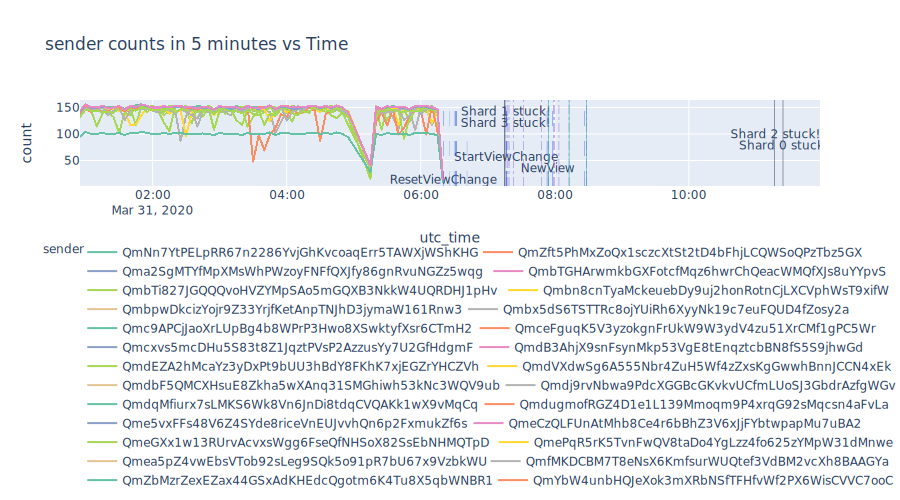

In [14]:
draw_error(agg, dict(list(alert.items())[0: 4]), viewchange, 5, 'sender')